# Temperaturas Ciudades

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
#ciudades = df.query('city == "Akron" | city == "Cincinnati"')
#ciudad = df.query('city == "Lincoln"')

#dfjoinCiudades = df.query('city == "Cincinnati"').join(df.query('city == "Akron"').set_index("ordinal"), on='ordinal', lsuffix='_cin', rsuffix='_akr_')
#ciudad = df.query('city == "Lincoln"')
#df[df["date"] > datetime(1999,1,1)].pivot("city", "avg")

In [27]:
#Se predice por año, NO MES, se hace un avg del año

def dataFrameEnFecha(df, year, qtty):
    """ Devuelve un dataframe desde year hasta year+qtty
    """
    df = df[df['year'] >= year]
    return df[df['year'] < year+qtty]


def pasoComunGenDF(df, calAvg):
    listCities = list(set(df['city']))
    listCitiesQuery = list(set(df['city']))
    for i in range(len(listCitiesQuery)):
        listCitiesQuery[i] = '"' + listCitiesQuery[i] + '"'

    dicCities = {}
    for i in range(len(listCities)):
        #Genero un nuevo dataframe, calculo el avg anual y elimino las filas duplicadas del año y columna 'avg'
        dfCity = pd.DataFrame(df.query('city == ' + listCitiesQuery[i]))

        if(calAvg):
            listAvgYr = list(dfCity.groupby('year').apply(lambda x: x.sum()/12)['avg'])
            dfCity.drop_duplicates(subset='year', inplace=True)
            del dfCity['avg']
            dfCity['avg'] = listAvgYr

        #Agrego el dataframe a un dic
        dicCities[listCities[i]] = dfCity
    
    return dicCities


def genDFAvgYr(df):
    """ Devuelve un dataframe que tiene solo promedio anual
    """
    dicCities = pasoComunGenDF(df, True)
    valDf = list(dicCities.values())
    return pd.concat(valDf)


def generarDFXS(df, varList):
    """ Genero un dataframe con los xs para pasarle a la funcion
    """
    dicCities = pasoComunGenDF(df, False)

    #Genero el dataframe para retornar
    yearCol = list(set(df['year']))
    dfXs = pd.DataFrame()
    for k,v in dicCities.items():
        for c in varList:
            dfXs[c+ " " + k] = list(v[c])
    dfXs['year'] = yearCol
    
    return dfXs


def getListXS(df):
    temp=[]
    for row in df.iterrows():
        index, data = row
        temp.append(data.tolist())
    return [data for index, data in df.iterrows()]


def resolver(dfCity, dfLotOfCities, yrFromT, qttyYrFromT, yrFromP, qttyYrFromP, funcion):
    #TRAINING
    dfCityT = dfCity.copy(deep=True)
    dfLotOfCitiesT = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityT = dataFrameEnFecha(dfCityT, yrFromT, qttyYrFromT)
    dfLotOfCitiesT = dataFrameEnFecha(dfLotOfCitiesT, yrFromT, qttyYrFromT)
    fechasT = list(dfLotOfCitiesT['year'])

    #Con esto genero una lista con los x para pasarle a cml
    xsT = dfLotOfCitiesT.values.tolist()
    ysT = list(dfCityT['avg'])

    funCML = cml(funcion, xsT, ysT)
    resXST = [funCML(x) for x in xsT]

    #PREDICTION
    dfCityP = dfCity.copy(deep=True)
    dfLotOfCitiesP = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityP = dataFrameEnFecha(dfCityP, yrFromP, qttyYrFromP)
    dfLotOfCitiesP = dataFrameEnFecha(dfLotOfCitiesP, yrFromP, qttyYrFromP)
    fechasP = list(dfLotOfCitiesP['year'])

    xsP = dfLotOfCitiesP.values.tolist()
    ysP = list(dfCityP['avg'])
    resXSP = [funCML(x) for x in xsP]
    
    return (fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP)


def calcularDatosEnChunks(dfCity, dfLotOfCities, yrFrom, yrsPerChunk, yrStop, funcion):
    dicChunks = {}
    qttyYrs = yrStop - yrFrom
    yrs = 0
    nbrChunk = 0
    while qttyYrs > 0:
        yrs += yrsPerChunk
        if yrs + yrFrom > yrStop:
            yrs -= yrsPerChunk
            aux = yrs
            yrs = yrStop - (yrFrom+yrs)
            yrs += aux
        print('yrs: ', yrs)
        print('yrFrom+yrs+1', yrFrom+yrs+1)
        dicChunks["chunk " + str(nbrChunk)] = resolver(dfCity, dfLotOfCities, yrFrom, yrs, yrFrom+yrs+1, 1, funcion)
        qttyYrs -= yrsPerChunk
        nbrChunk += 1
    return dicChunks

In [4]:
#LEVANTO DATOS
dfWest = pd.read_csv('data/CitiesWestChunk.csv', parse_dates = [0])
dfEast = pd.read_csv('data/CitiesEastChunk.csv', parse_dates = [0])
dfWest.sort_values(['date','country','city'], inplace = True)
dfEast.sort_values(['date','country','city'], inplace = True)

#ME QUEDO CON LOS DATOS DE FECHAS COMUNES EN TODAS
#Datos de 1849 a 2013
minWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minTotal = max(minWest, minEast)
maxTotal = min(maxWest, maxWest)
dfWest = dfWest[dfWest['date'] >= minTotal]
dfWest = dfWest[dfWest['date'] < maxTotal]
dfEast = dfEast[dfEast['date'] >= minTotal]
dfEast = dfEast[dfEast['date'] < maxTotal]

#dfWest['ordinal']= dfWest['date'].apply(lambda x: x.toordinal())
dfWest["year"] = dfWest["date"].apply(lambda d: d.year)
#dfEast['ordinal']= dfEast['date'].apply(lambda x: x.toordinal())
dfEast["year"] = dfEast["date"].apply(lambda d: d.year)

#Genero promedio anual y quito promedio mensual
dfWest = genDFAvgYr(dfWest)
dfEast = genDFAvgYr(dfEast)

groupByCitiesW = dfWest.groupby('city')
groupByCitiesE = dfEast.groupby('city')

In [5]:
#funcion lineal cabeza, probar otras
#me hago un df para un ordinal tener todas las temperaturas de todas las ciudades (altitud tambien?)

In [5]:
#Para cada w in CitiesW, calcular(w, CitiesE)
#Para cada e in CitiesE, calcular(e, CitiesW)
listCitiesWest = list(set(dfWest['city']))
listCitiesEast = list(set(dfEast['city']))
listXs = ['avg','altitude','year']
dfW = generarDFXS(dfWest, listXs)
dfE = generarDFXS(dfEast, listXs)

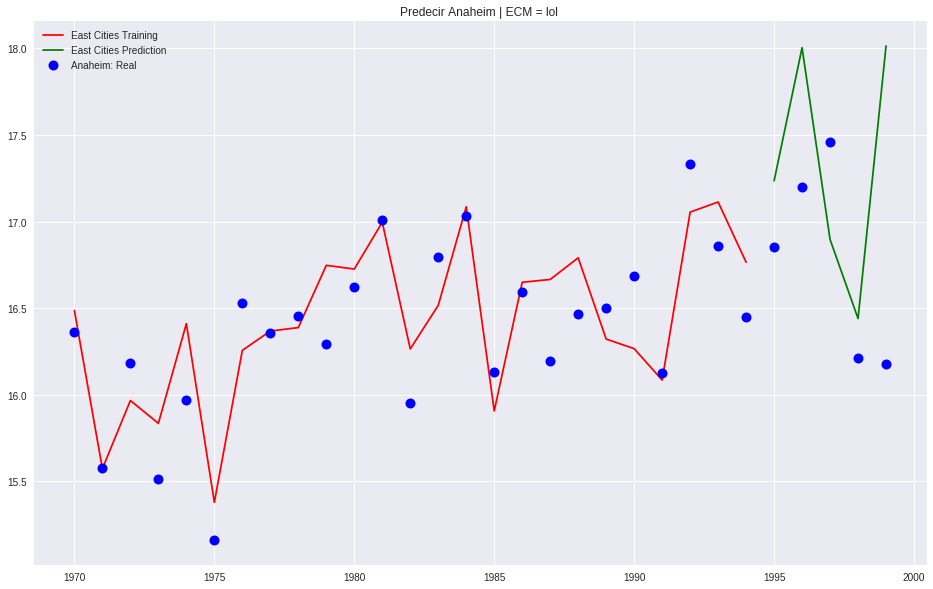

In [25]:
#TEST: tomo la ciudad idxCity del lado oeste e intento predecirla con todas las del este
idxCity = 2

dfCity = groupByCitiesW.get_group(listCitiesWest[idxCity])
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP = resolver(dfCity, dfe, 1970, 25, 1995, 5, funcion)

plt.plot(fechasT, resXST, 'r', label='East Cities Training', color='red')
plt.plot(fechasP, resXSP, 'r', label='East Cities Prediction', color='green')

plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=listCitiesWest[idxCity]+': Real', markersize=10, color='blue')

plt.title('{} | ECM = {} '.format("Predecir "+ listCitiesWest[idxCity], 'lol') )
plt.legend()
plt.show()

yrs:  10
yrFrom+yrs+1 1911
yrs:  20
yrFrom+yrs+1 1921
yrs:  30
yrFrom+yrs+1 1931
yrs:  40
yrFrom+yrs+1 1941
yrs:  50
yrFrom+yrs+1 1951
yrs:  60
yrFrom+yrs+1 1961
yrs:  70
yrFrom+yrs+1 1971
yrs:  80
yrFrom+yrs+1 1981
yrs:  90
yrFrom+yrs+1 1991
yrs:  92
yrFrom+yrs+1 1993
error year <= 1911 -> 0.028366257555274405
error year <= 1921 -> 0.832286225289714
error year <= 1931 -> 0.018211129703777036
error year <= 1941 -> 1.1621273919408397
error year <= 1951 -> 0.10523541837591063
error year <= 1961 -> 0.02861997729904823
error year <= 1971 -> 0.9524042676424224
error year <= 1981 -> 1.118326863245263
error year <= 1991 -> 0.0010617516210223265
error year <= 1993 -> 0.16531215847685082


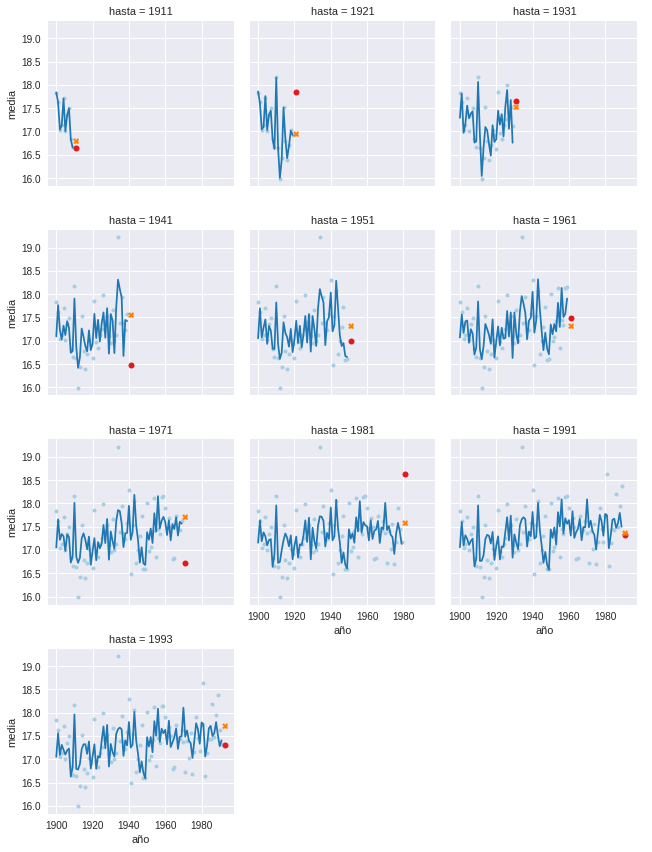

In [29]:
#def pp(x, y, data, **kwargs):
#    c = data['chunk'].values[0]
#    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
#    plt.plot(fechas_c[c], temps_c[c], 'o', label='Training', markersize=4)
#    plt.plot(lol, data['x'].values[0], 'r', label='CML')
    
#l = sns.FacetGrid(df2, col="chunk", row="grade", size=3)
#l.map_dataframe(pp, 'fechas', 'temps')
#l.add_legend()

#def calcularDatosEnChunks(dfCity, dfLotOfCities, yrFrom, qttyYrsStart, yrStop, funcion):
#    dicChunks = {}
#    for i in range(qttyYrs):
#        dicChunks[i] = resolver(dfCity, dfLotOfCities, yrFrom, qttyYrsStart+i, yrStop, 1, funcion)
#    return dicChunks

# fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP

idxCity = 0

dfCity = groupByCitiesW.get_group(listCitiesWest[idxCity])
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 1992, funcion)
#print(len(dicChunks))

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']
#print(df2)
#print(dicChunks[8])

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
hastaList = []
for f in list(df2['fechasP']):
    hastaList.append(f[0])
df2['hasta'] = hastaList
df2.sort_values('hasta', inplace=True)
#print(df2)

def funcForPlot(x, y, **kwargs):
    palette = sns.color_palette('Paired', 12)
    #print("args: ", args)
    #print("kargs: ", kwargs)
    data = kwargs.pop('data')
    #fechasT -> x
    #ysT -> y
    plt.plot(list(data['fechasT'])[0], list(data['ysT'])[0], 'o', label='Entrenamiento', markersize=4, color=palette[0])
    #fechasT -> x
    #resXST -> y
    plt.plot(list(data['fechasT'])[0], list(data['resXST'])[0], 'r', label='CML', color=palette[1])
    #fechasP -> x
    #ysP -> y
    plt.plot(list(data['fechasP'])[0], list(data['ysP'])[0], 'o', label='Real', markersize=6, color=palette[5])
    #fechasP -> x
    #ysP -> y
    plt.plot(list(data['fechasP'])[0], list(data['resXSP'])[0], 'X', label='Predicción', markersize=6, color=palette[7])

    #calculo ecm
    err = ecm(list(data['resXSP'])[0], list(data['ysP'])[0])
    print('error year <= {} -> {}'.format(list(data['hasta'])[0], err))


l = sns.FacetGrid(df2, col="hasta", col_wrap=3, size=3)
l.add_legend()
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año')\
    .set_ylabels('media')